<a href="https://colab.research.google.com/github/LHMade/LH-Made-Cookies/blob/main/sori_LHMadeCookies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files
uploaded = files.upload()

Saving 10.성남시_지하철역.csv to 10.성남시_지하철역.csv


In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.spatial import cKDTree
from xgboost import XGBRegressor

# **성남시 데이터 전처리**

In [28]:
# 파일 경로 설정
file_paths = {
    "거주인구": "/content/1.성남시_거주인구.csv",
    "상권정보": "/content/2.성남시_상권정보.csv",
    "상가개폐업": "/content/3.성남시_상가개폐업.csv",
    "표제부": "/content/4.성남시_표제부.csv",
    "층별개요": "/content/5.성남시_층별개요.csv",
    "지식산업센터": "/content/7.성남시_지식산업센터.csv",
    "개별공시지가": "/content/8.성남시_개별공시지가.csv",
    "버스정류장": "/content/9.성남시_버스정류장.csv",
    "지하철역": "/content/10.성남시_지하철역.csv"
}

dataframes = {}
for name, path in file_paths.items():
    try:
        dataframes[name] = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        dataframes[name] = pd.read_csv(path, encoding="cp949")

<ipython-input-28-cc99fbd2fb22>:17: DtypeWarning: Columns (14,15,34,58,59,60,61,67) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[name] = pd.read_csv(path, encoding="utf-8")
<ipython-input-28-cc99fbd2fb22>:17: DtypeWarning: Columns (10,11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[name] = pd.read_csv(path, encoding="utf-8")


In [29]:
# 공간 매핑 및 거리 계산
def convert_to_gdf(df, lon_col, lat_col):
    df = df.dropna(subset=[lon_col, lat_col])
    df["geometry"] = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf_industrial = convert_to_gdf(dataframes["지식산업센터"], "lon", "lat")
gdf_bus = convert_to_gdf(dataframes["버스정류장"], "lon", "lat")
gdf_subway = convert_to_gdf(dataframes["지하철역"], "lon", "lat")

def calculate_nearest_distance(source_gdf, target_gdf):
    distances = []
    for src_point in source_gdf.geometry:
        min_distance = target_gdf.distance(src_point).min() * 111
        distances.append(min_distance)
    return distances

gdf_industrial["bus_distance_km"] = calculate_nearest_distance(gdf_industrial, gdf_bus)
gdf_industrial["subway_distance_km"] = calculate_nearest_distance(gdf_industrial, gdf_subway)

<ipython-input-29-b3659c130af6>:14: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  min_distance = target_gdf.distance(src_point).min() * 111
<ipython-input-29-b3659c130af6>:14: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  min_distance = target_gdf.distance(src_point).min() * 111


In [30]:
# 상권 정보 및 추가 변수 결합
gdf_commercial = convert_to_gdf(dataframes["상권정보"], "lon", "lat")

def count_nearby_stores_fast(center_gdf, store_gdf, radius=1000):
    center_coords = np.array(list(zip(center_gdf.geometry.x, center_gdf.geometry.y)))
    store_coords = np.array(list(zip(store_gdf.geometry.x, store_gdf.geometry.y)))
    tree = cKDTree(store_coords)
    counts = tree.query_ball_point(center_coords, radius)
    return [len(c) for c in counts]

gdf_industrial["nearby_store_count"] = count_nearby_stores_fast(gdf_industrial, gdf_commercial)

In [31]:
# 개별공시지가, 층별 개요, 상가 개폐업 데이터 결합
df_land_value = dataframes["개별공시지가"].copy()
df_land_value_avg = df_land_value.groupby("bjd_nm")["land_value"].mean().reset_index()
gdf_industrial = gdf_industrial.merge(df_land_value_avg, left_on="addr", right_on="bjd_nm", how="left")

df_population = dataframes["거주인구"].copy()
df_population["total_population"] = df_population.iloc[:, 2:].sum(axis=1)
gdf_industrial = gdf_industrial.merge(df_population[["gid", "total_population"]], left_on="addr", right_on="gid", how="left")

# 층별 개요 데이터 (최대 층수 활용)
df_building_floors = dataframes["층별개요"].copy()
df_floors_grouped = df_building_floors.groupby("plat_plc")["flr_num"].max().reset_index()
gdf_industrial = gdf_industrial.merge(df_floors_grouped, left_on="addr", right_on="plat_plc", how="left")

# 상가 개폐업 데이터 (폐업 및 개업 수 활용)
df_shop_open_close = dataframes["상가개폐업"].copy()
df_shop_grouped = df_shop_open_close.groupby("addr")["biz_stts_nm"].count().reset_index()
df_shop_grouped.rename(columns={"biz_stts_nm": "num_business_changes"}, inplace=True)
gdf_industrial = gdf_industrial.merge(df_shop_grouped, left_on="addr", right_on="addr", how="left")

**상관관계 분석**

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


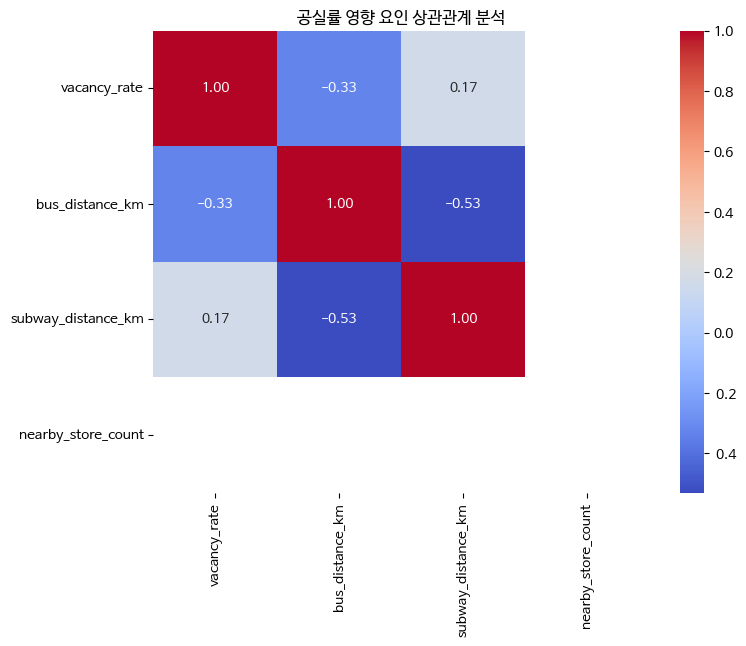

In [21]:
# 공실률 계산
gdf_industrial["vacancy_rate"] = 1 - (gdf_industrial["cpn_in_2406"] / gdf_industrial["tot_cpn"])
gdf_industrial["vacancy_rate"] = gdf_industrial["vacancy_rate"].fillna(0)

# 공실률 영향 요인 분석 (상관관계 분석)
correlation_data = gdf_industrial[["vacancy_rate", "bus_distance_km", "subway_distance_km", "nearby_store_count"]]
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("공실률 영향 요인 상관관계 분석")
plt.show()

**랜덤포레스트 공실률 예측 성분 분석**

In [18]:
# 랜덤 포레스트 기반 공실률 예측
features = ["bus_distance_km", "subway_distance_km", "nearby_store_count", "total_population"]
X = gdf_industrial[features].fillna(0)
y = gdf_industrial["vacancy_rate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"✅ 평균 절대 오차 (MAE): {mae_rf:.4f}")
print(f"✅ 결정계수 (R² 점수): {r2_rf:.4f}")

✅ 평균 절대 오차 (MAE): 0.2561
✅ 결정계수 (R² 점수): -0.8951


**XGBoost 공실률 예측 성분 분석**

In [32]:
# 공실률 계산 및 모델 개선
gdf_industrial["vacancy_rate"] = 1 - (gdf_industrial["cpn_in_2406"] / gdf_industrial["tot_cpn"])
gdf_industrial["vacancy_rate"] = gdf_industrial["vacancy_rate"].fillna(0)

features = ["bus_distance_km", "subway_distance_km", "nearby_store_count", "total_population", "flr_num", "num_business_changes"]
X = gdf_industrial[features].fillna(0)
y = gdf_industrial["vacancy_rate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"✅ 평균 절대 오차 (MAE): {mae_xgb:.4f}")
print(f"✅ 결정계수 (R² 점수): {r2_xgb:.4f}")

✅ 평균 절대 오차 (MAE): 0.2821
✅ 결정계수 (R² 점수): -1.2416
